In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import nibabel as nib
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import time
from pathlib import Path
from datetime import datetime
from tqdm import tqdm
import json
import torch.optim as optim
import torch.nn.functional as F

In [2]:
import psutil

def print_memory_info():
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()

    print(f"Python process RAM usage: {mem_info.rss / 1e9:.2f} GB")

print_memory_info()

Python process RAM usage: 0.46 GB


## Data

The following code creates a temporary in-memory file system and loads the training data into there. This is a workaround for the fact that there isn't enough space on the UGent HPC.

In [3]:
import sys
sys.path.append("/home/a3j/school/dl/project")
import utils.hpc

DATA_DIR = utils.hpc.load_dataset_into_ram() if utils.hpc.running_on_hpc() else "/home/a3j/school/dl/project/3d/data/partial/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

print(f'Running on {"hpc" if utils.hpc.running_on_hpc() else "personal computer"}')
print(f'Using {"full dataset" if utils.hpc.running_on_hpc() else "partial dataset (10 patients)"}')
print(f'path: {DATA_DIR}')

Running on personal computer
Using partial dataset (10 patients)
path: /home/a3j/school/dl/project/3d/data/partial/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData


In [4]:
def get_all_patient_folders(data_dir=DATA_DIR, broken_patients=["BraTS20_Training_355"]):
    all_patients = sorted([
        f for f in os.listdir(data_dir)
        if os.path.isdir(os.path.join(data_dir, f)) and not f in broken_patients
    ])

    return all_patients

MODALITIES = ["flair", "t1", "t1ce", "t2"]

patient_folders = get_all_patient_folders()

print(f'Found {len(patient_folders)} patient folders')

Found 4 patient folders


(240, 240, 155)
0 (240, 240, 155) flair
1 (240, 240, 155) t1
2 (240, 240, 155) t1ce
3 (240, 240, 155) t2


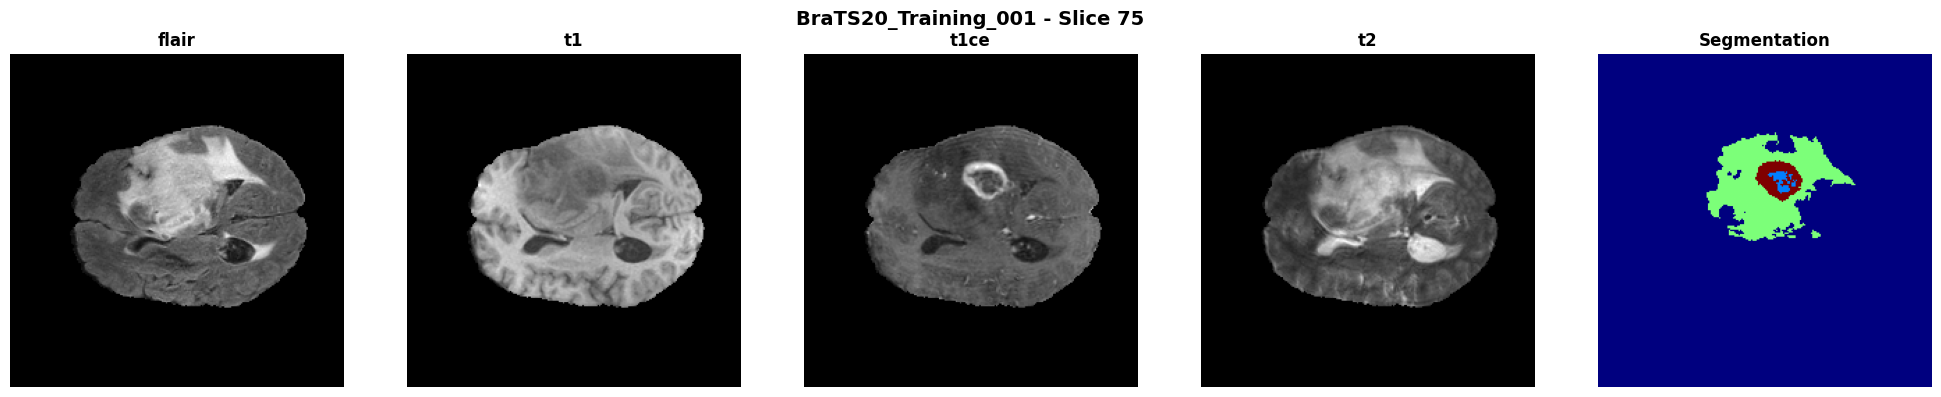

In [5]:
def display_patient(pid, slice_idx):
    path = f'{DATA_DIR}/{pid}'

    imgs = []
    for mod in MODALITIES:
        file_path = os.path.join(path, f"{pid}_{mod}.nii")
        img = nib.load(file_path).get_fdata(dtype=np.float32)
        imgs.append(img)

    seg_path = os.path.join(path, f"{pid}_seg.nii")
    seg = nib.load(seg_path).get_fdata(dtype=np.float32)

    print(imgs[0].shape)

    fig, axes = plt.subplots(1, 5, figsize=(20, 4))

    # Plot all 4 modalities
    for i, (img, mod) in enumerate(zip(imgs, MODALITIES)):
        print(i, img.shape, mod)
        axes[i].imshow(img[:, :, slice_idx], cmap='gray')
        axes[i].set_title(mod, fontsize=12, fontweight='bold')
        axes[i].axis('off')

    # Plot segmentation with color-coded tumor regions
    axes[4].imshow(seg[:, :, slice_idx], cmap='jet', vmin=0, vmax=4)
    axes[4].set_title('Segmentation', fontsize=12, fontweight='bold')
    axes[4].axis('off')

    plt.suptitle(f'{pid} - Slice {slice_idx}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

display_patient(patient_folders[0], 75)

## Creating access to the dataset

In [6]:
def pad_to_multiple(tensor, multiple=16):
    if tensor.dim() == 3:
        d, h, w = tensor.shape
    elif tensor.dim() == 4:
        c, d, h, w = tensor.shape
    else:
        raise ValueError(f"Unsupported tensor shape: {tensor.shape}")

    pad_d = (multiple - d % multiple) % multiple
    pad_h = (multiple - h % multiple) % multiple
    pad_w = (multiple - w % multiple) % multiple
    # F.pad pads in order: (W_left, W_right, H_top, H_bottom, D_front, D_back)
    return F.pad(tensor, (0, pad_w, 0, pad_h, 0, pad_d))

In [7]:
def load_patient(patient_id):
    """Load all modalities and segmentation for one patient"""
    patient_path = os.path.join(DATA_DIR, patient_id)
    modalities = MODALITIES

    image_arrays = []
    for mod in modalities:
        file_path = os.path.join(patient_path, f"{patient_id}_{mod}.nii")
        img = nib.load(file_path).get_fdata(dtype=np.float32)
        image_arrays.append(img)

    seg_path = os.path.join(patient_path, f"{patient_id}_seg.nii")
    seg = nib.load(seg_path).get_fdata(dtype=np.float32)

    # Stack modalities -> shape (4, D, H, W)
    image = np.stack(image_arrays, axis=0)
    #seg = np.expand_dims(seg, axis=0)  # shape (1, D, H, W)

    print(image.shape)
    print(seg.shape)

    seg[seg==4] = 3 # remap label 4 to 3 to preserve continuity (there is no label 3 in the data)

    # Normalize each modality to [0, 1]
    image = (image - image.min(axis=(1,2,3), keepdims=True)) / (
        image.max(axis=(1,2,3), keepdims=True) - image.min(axis=(1,2,3), keepdims=True) + 1e-8
    )

    # Convert to torch tensors
    image = torch.from_numpy(image).float()
    seg = torch.from_numpy(seg).long()

    # fix issues with height not being properly divisible
    image = pad_to_multiple(image)
    seg = pad_to_multiple(seg)

    print(image.shape)
    print(seg.shape)

    return image, seg

load_patient(patient_folders[0])

(4, 240, 240, 155)
(240, 240, 155)
torch.Size([4, 240, 240, 160])
torch.Size([240, 240, 160])


(tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          ...,
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
       

In [8]:
class BraTSDataset3D(Dataset):
    """
    PyTorch Dataset for BraTS 2020 Brain Tumor Segmentation (2D U-Net)
    
    Design Decisions:
    1. Filter empty slices: Only keep slices with tumor pixels (labels 1,2,4)
    2. Label remapping: {0,1,2,4} → {0,1,2,3} for PyTorch compatibility
    3. Normalization: Percentile clipping + Z-score on BRAIN REGION ONLY
    4. Input: 4-channel (T1, T1ce, T2, FLAIR) x 240x240 full slices
    5. Patient-level split: Prevent data leakage
    """
        
    def __init__(self, data_dir, patient_ids=None, transform=None, in_memory=False):
        """
        Args:
            data_dir (str): Path or filesystem handle to training data (with patient folders)
            patient_ids (list[str], optional): Subset of patient folder names
            transform (callable, optional): Transform applied to each sample
            in_memory (bool): If True, preloads all patients into RAM
        """
        self.data_dir = data_dir
        self.transform = transform

        # Gather all patient folders
        self.patient_ids = patient_ids or get_all_patient_folders(data_dir)

        self.in_memory = in_memory
        if in_memory:
            print("🧠 Preloading all patient data into memory...")
            self.cache = {pid: self._load_patient(pid) for pid in self.patient_ids}
        else:
            self.cache = {}        

    def _load_patient(self, patient_id):
        """Load all modalities and segmentation for one patient"""
        patient_path = os.path.join(self.data_dir, patient_id)
        modalities = MODALITIES

        image_arrays = []
        for mod in modalities:
            file_path = os.path.join(patient_path, f"{patient_id}_{mod}.nii")
            img = nib.load(file_path).get_fdata(dtype=np.float32)
            image_arrays.append(img)

        seg_path = os.path.join(patient_path, f"{patient_id}_seg.nii")
        seg = nib.load(seg_path).get_fdata(dtype=np.float32)

        # Stack modalities -> shape (4, D, H, W)
        image = np.stack(image_arrays, axis=0)
        #seg = np.expand_dims(seg, axis=0)  # shape (1, D, H, W)

        seg[seg==4] = 3 # remap label 4 to 3 to preserve continuity (there is no label 3 in the data)

        return image, seg
    
    def __len__(self):
        return len(self.patient_ids)
    
    def __getitem__(self, idx):
        pid = self.patient_ids[idx]
        if pid in self.cache:
            image, seg = self.cache[pid]
        else:
            image, seg = self._load_patient(pid)

        # Normalize each modality to [0, 1]
        image = (image - image.min(axis=(1,2,3), keepdims=True)) / (
            image.max(axis=(1,2,3), keepdims=True) - image.min(axis=(1,2,3), keepdims=True) + 1e-8
        )

        # Apply transform if any
        if self.transform:
            image, seg = self.transform(image, seg)

        # Convert to torch tensors
        image = torch.from_numpy(image).float()
        seg = torch.from_numpy(seg).long()

        # fix issues with height not being properly divisible
        image = pad_to_multiple(image)
        seg = pad_to_multiple(seg)

        return image, seg
    
    def _convert_labels(self, mask):
        """
        Remap labels from {0,1,2,4} to {0,1,2,3}
        
        Original BraTS labels:
            0 = Background
            1 = Necrotic/Non-enhancing tumor
            2 = Edema
            4 = Enhancing tumor
        
        Remapped labels (for PyTorch):
            0 = Background
            1 = Necrotic/Non-enhancing tumor
            2 = Edema
            3 = Enhancing tumor
        
        Args:
            mask (np.ndarray): Segmentation mask with original labels
        
        Returns:
            np.ndarray: Mask with remapped labels
        """
        mask = mask.copy()
        mask[mask == 4] = 3  # Remap enhancing tumor
        return mask


In [9]:
from sklearn.model_selection import train_test_split

def create_split(pids=None, train=0.7, val=0.15, test=0.15):
    if not pids:
        pids = sorted(get_all_patient_folders())

    train_ids, temp_ids = train_test_split(pids, test_size=val+test, random_state=42)
    val_ids, test_ids = train_test_split(temp_ids, test_size=test/(val+test), random_state=42)

    return train_ids, val_ids, test_ids

## The model

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm3d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet3D(nn.Module):
    def __init__(self, in_channels=4, out_channels=4):
        super().__init__()
        self.enc1 = DoubleConv(in_channels, 32)
        self.enc2 = DoubleConv(32, 64)
        self.enc3 = DoubleConv(64, 128)
        self.enc4 = DoubleConv(128, 256)

        self.pool = nn.MaxPool3d(2)

        self.bottleneck = DoubleConv(256, 512)

        self.up4 = nn.ConvTranspose3d(512, 256, 2, stride=2)
        self.dec4 = DoubleConv(512, 256)
        self.up3 = nn.ConvTranspose3d(256, 128, 2, stride=2)
        self.dec3 = DoubleConv(256, 128)
        self.up2 = nn.ConvTranspose3d(128, 64, 2, stride=2)
        self.dec2 = DoubleConv(128, 64)
        self.up1 = nn.ConvTranspose3d(64, 32, 2, stride=2)
        self.dec1 = DoubleConv(64, 32)

        self.out_conv = nn.Conv3d(32, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d4 = self.up4(b) 
        d4 = self.dec4(torch.cat([d4, e4], dim=1)) 
        d3 = self.up3(d4) 
        d3 = self.dec3(torch.cat([d3, e3], dim=1)) 
        d2 = self.up2(d3) 
        d2 = self.dec2(torch.cat([d2, e2], dim=1)) 
        d1 = self.up1(d2) 
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        return self.out_conv(d1)
    
def create_model(in_channels=4, out_channels=4, device=None):
    """
    Create U-Net model and move to appropriate device
    
    Args:
        n_channels (int): Number of input channels
        n_classes (int): Number of output classes
        bilinear (bool): Use bilinear upsampling
        dropout_p (float): Dropout probability
        device (str or torch.device): Device to use (None = auto-detect)
    
    Returns:
        model: U-Net model on specified device
        device: The device being used
    """
    # Create model
    model = UNet3D(
        in_channels=in_channels,
        out_channels=out_channels,
    )

    model = model.to(device)
    
    return model

## Loss functions

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        """
        logits: (N, C, D, H, W) raw output from model (not softmaxed)
        targets: (N, D, H, W) ground truth with class indices 0..C-1
        """
        num_classes = logits.shape[1]

        # Apply softmax over the class dimension
        probs = F.softmax(logits, dim=1)

        # One-hot encode the targets
        targets_onehot = F.one_hot(targets, num_classes).permute(0, 4, 1, 2, 3).float()

        # Compute Dice per class
        dims = (0, 2, 3, 4)
        intersection = torch.sum(probs * targets_onehot, dims)
        cardinality = torch.sum(probs + targets_onehot, dims)

        dice_score = (2. * intersection + self.smooth) / (cardinality + self.smooth)
        dice_loss = 1. - dice_score

        # Average over classes
        return dice_loss.mean()
        

class CombinedLoss(nn.Module):
    def __init__(self, weight_dice=1.0, weight_ce=1.0):
        super(CombinedLoss, self).__init__()
        self.weight_dice = weight_dice
        self.weight_ce = weight_ce
        self.dice = DiceLoss()
        self.ce = nn.CrossEntropyLoss()

    def forward(self, logits, targets):
        ce_loss = self.ce(logits, targets)
        dice_loss = self.dice(logits, targets)
        return self.weight_ce * ce_loss + self.weight_dice * dice_loss

## Metrics

In [12]:
class SegmentationMetrics:
    """
    Compute segmentation metrics for multi-class 3D images.
    
    Usage:
        metrics = SegmentationMetrics(num_classes=4, ignore_background=True, device='cuda')
        metrics.update(preds, targets)
        summary = metrics.get_metrics()
        metrics.reset()
    """
    
    def __init__(self, num_classes=4, ignore_background=True, device='cuda'):
        self.num_classes = num_classes
        self.ignore_background = ignore_background
        self.device = device
        self.reset()
    
    def reset(self):
        self.intersections = torch.zeros(self.num_classes, device=self.device)
        self.unions = torch.zeros(self.num_classes, device=self.device)
        self.correct_pixels = 0
        self.total_pixels = 0
        self.total_batches = 0
    
    def update(self, preds, targets):
        """
        preds: torch.Tensor of shape [B, C, H, W, D] (logits)
        targets: torch.Tensor of shape [B, H, W, D] (integer labels)
        """
        # Convert logits to predicted class labels
        if preds.dim() == targets.dim() + 1:
            preds = torch.argmax(preds, dim=1)
        
        preds = preds.to(self.device)
        targets = targets.to(self.device)
        
        # Pixel accuracy
        self.correct_pixels += (preds == targets).sum()
        self.total_pixels += torch.numel(targets)
        
        # Compute intersection & union per class
        for cls in range(self.num_classes):
            if self.ignore_background and cls == 0:
                continue
            pred_mask = (preds == cls)
            target_mask = (targets == cls)
            intersection = (pred_mask & target_mask).sum()
            union = (pred_mask | target_mask).sum()
            
            self.intersections[cls] += intersection
            self.unions[cls] += union
        
        self.total_batches += 1
    
    def get_metrics(self):
        """
        Returns a dictionary with mean dice, mean IoU, pixel accuracy,
        and per-class dice/IoU
        """
        # Dice: 2 * intersection / (pred + target)
        dice_per_class = torch.zeros(self.num_classes, device=self.device)
        iou_per_class = torch.zeros(self.num_classes, device=self.device)
        
        for cls in range(self.num_classes):
            if self.ignore_background and cls == 0:
                dice_per_class[cls] = float('nan')
                iou_per_class[cls] = float('nan')
                continue
            inter = self.intersections[cls].float()
            union = self.unions[cls].float()
            dice_per_class[cls] = 2 * inter / (union + inter + 1e-8)
            iou_per_class[cls] = inter / (union + 1e-8)
        
        # Mean dice & IoU (excluding background if desired)
        valid_dice = dice_per_class[1:] if self.ignore_background else dice_per_class
        valid_iou = iou_per_class[1:] if self.ignore_background else iou_per_class
        
        mean_dice = valid_dice[~torch.isnan(valid_dice)].mean().item()
        mean_iou = valid_iou[~torch.isnan(valid_iou)].mean().item()
        pixel_acc = (self.correct_pixels.float() / self.total_pixels).item()
        
        return {
            'mean_dice': mean_dice,
            'mean_iou': mean_iou,
            'mean_pixel_acc': pixel_acc,
            'dice_per_class': dice_per_class.cpu().tolist(),
            'iou_per_class': iou_per_class.cpu().tolist()
        }


## Helper functions

In [13]:
def save_model(model, epoch, optimizer, val_dice, val_loss, train_metrics_dict, val_metrics_dict, save_dir, final=False):
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_dice': val_dice,
        'val_loss': val_loss,
        'train_metrics': train_metrics_dict, 
        'val_metrics': val_metrics_dict,
    }
    
    today = datetime.now().strftime("%Y%m%d_%H%M%S")
    torch.save(checkpoint, save_dir / f'{today}_{"final" if final else "best"}_model.pth')

def save_history(history, save_dir):
    today = datetime.now().strftime("%Y%m%d_%H%M%S")
    history_file = save_dir / f'{today}_training_history.json'
    with open(history_file, 'w') as f:
        json.dump(history, f, indent=4)


In [14]:
def update_history(history, train_loss, val_loss, train_metrics_dict, val_metrics_dict, epoch_time):
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_dice'].append(train_metrics_dict['mean_dice'])
    history['val_dice'].append(val_metrics_dict['mean_dice'])
    history['train_iou'].append(train_metrics_dict['mean_iou'])
    history['val_iou'].append(val_metrics_dict['mean_iou'])
    history['train_pixel_acc'].append(train_metrics_dict['mean_pixel_acc'])
    history['val_pixel_acc'].append(val_metrics_dict['mean_pixel_acc'])
    history['epoch_times'].append(epoch_time)

## Training loop

In [15]:
def train_epoch(model, loader, loss_fn, optimizer, device, metrics, verbose=True):
    model.train()
    
    running_loss = 0.0
    num_batches = 0
    
    if verbose:
        loader = tqdm(loader, desc='Training', ncols=100)
    
    for batch_idx, (inputs, targets) in enumerate(loader):
        # Move to device
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Compute loss
        loss = loss_fn(outputs, targets.squeeze(1))
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        # Track running loss
        running_loss += loss.item()
        num_batches += 1
        
        # Optionally compute batch metrics
        metrics.update(outputs.detach(), targets.detach())
        
        if verbose:
            avg_loss = running_loss / num_batches
            loader.set_postfix({'loss': f'{avg_loss:.4f}'})
    
    # Average epoch loss
    epoch_loss = running_loss / num_batches
    
    # Get metrics summary (if any)
    metrics_summary = metrics.get_metrics()
    
    return epoch_loss, metrics_summary

def validate_epoch(model, loader, loss_fn, device, metrics):
    model.eval()
    metrics.reset()
    running_loss = 0.0
    num_batches = 0

    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(loader):
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)

            # Compute loss
            loss = loss_fn(outputs, masks.squeeze(1))
            running_loss += loss.item()
            num_batches += 1

            # Update metrics
            metrics.update(outputs, masks)

    avg_loss = running_loss / max(num_batches, 1)
    metrics_dict = metrics.get_metrics()

    return avg_loss, metrics_dict

In [16]:
def train_model(model, train_loader, val_loader, loss_fn, optimizer, device, save_dir="checkpoints", epochs=20, scheduler=None, early_stopping_patience=None):
    save_dir = Path(save_dir)
    save_dir.mkdir(exist_ok=True, parents=True)

    train_metrics = SegmentationMetrics(num_classes=4, ignore_background=True, device=device)
    val_metrics = SegmentationMetrics(num_classes=4, ignore_background=True, device=device)

    history = {
        'train_loss': [],
        'val_loss': [],
        'train_dice': [],
        'val_dice': [],
        'train_iou': [],
        'val_iou': [],
        'train_pixel_acc': [],
        'val_pixel_acc': [],
        'epoch_times': []
    }

    best_val_dice = 0.0
    best_epoch = 0
    epochs_without_improvement = 0

    for epoch in range(epochs):
        epoch_start_time = time.time()

        # training phase
        train_loss, train_metrics_dict = train_epoch(model, train_loader, loss_fn, optimizer, device, train_metrics)

        # validation phase
        val_loss, val_metrics_dict = validate_epoch(model, val_loader, loss_fn, device, val_metrics)

        # step scheduler
        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()


        epoch_time = time.time() - epoch_start_time

        # update history
        update_history(history, train_loss, val_loss, train_metrics_dict, val_metrics_dict, epoch_time)

        # show metrics
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Epoch time: {epoch_time:.2f}s")
        print(f"Train Dice: {train_metrics_dict['mean_dice']:.4f} | Val Dice: {val_metrics_dict['mean_dice']:.4f}")
        print(f"Train IoU: {train_metrics_dict['mean_iou']:.4f} | Val IoU: {val_metrics_dict['mean_iou']:.4f}")
        print(f"Train Pixel Acc: {train_metrics_dict['mean_pixel_acc']:.4f} | Val Pixel Acc: {val_metrics_dict['mean_pixel_acc']:.4f}")

        # save model if best
        val_dice = val_metrics_dict['mean_dice']

        if val_dice > best_val_dice:
            best_val_dice = val_dice
            best_epoch = epoch + 1
            epochs_without_improvement = 0

            save_model(model, epoch, optimizer, val_dice, val_loss, train_metrics_dict, val_metrics_dict, save_dir, final=False)
        else:
            epochs_without_improvement += 1

        if early_stopping_patience and epochs_without_improvement >= early_stopping_patience:
            print(f"Warning: Early stopping triggered")
            break

    # plot curves

    # save final model
    save_history(history, save_dir)


    return history

## Execution

In [17]:
device = torch.device("cuda:0")
device = torch.device("cpu")

print(f'Using device: {device}')

Using device: cpu


In [18]:
# create datasets
train_ids, val_ids, test_ids = create_split()

train_dataset = BraTSDataset3D(
    data_dir=DATA_DIR,
    patient_ids=train_ids,
    transform=None,
    in_memory=False,
)

val_dataset = BraTSDataset3D(
    data_dir=DATA_DIR,
    patient_ids=val_ids,
    transform=None,
    in_memory=False,
)

test_dataset = BraTSDataset3D(
    data_dir=DATA_DIR,
    patient_ids=test_ids,
    transform=None,
    in_memory=False,
)

# create dataloaders
BATCH_SIZE = 1
NUM_WORKERS = 1

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=False
)

# create model
model = create_model(device=device)
model = model.to(device)

# create loss function
loss_fn = CombinedLoss()

# create optimizer
learning_rate = 1e-4
weight_decay = 1e-5

optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [ ]:
history = train_model(model, train_loader, val_loader, loss_fn, optimizer, device)

Training: 100%|█████████████████████████████████████████| 2/2 [14:04<00:00, 422.05s/it, loss=2.5668]


Train Loss: 2.5668 | Val Loss: 2.4789 | Epoch time: 859.48s
Train Dice: 0.0163 | Val Dice: 0.0007
Train IoU: 0.0083 | Val IoU: 0.0003
Train Pixel Acc: 0.0048 | Val Pixel Acc: 0.0010


Training:   0%|                                                               | 0/2 [00:00<?, ?it/s]